In [1]:
import matplotlib.pyplot as plt
from pylab import imshow, figure, plot, colorbar, show, hist
%matplotlib inline

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
from keras.models import Model
from keras.optimizers import SGD, Adam, Nadam, RMSprop

import data
import datagen
import net

import random
import skimage.transform
import json
import pickle
import sklearn.metrics

import sys
import importlib
import datetime
import subprocess

SNAP_PATH = '/mnt/data/snap/'
localizer_output_dir = '/mnt/data/snap/localizer_output_k1_a/'
min_activity = 60

Using TensorFlow backend.
/home/alex/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [4]:
config_name = 'config_baseline3'
config = importlib.import_module(config_name)


In [5]:
model = net.model3d((16, 16, 16), sz=config.feature_sz, alpha=config.feature_alpha)


In [6]:
model.load_weights(SNAP_PATH + 'localizer_k1_a.h5')

In [3]:
df_nodes = data.ndsb17_get_df_nodes() 
df_nodes = df_nodes[(df_nodes["diameter_mm"]>=9)]

patient_ids = data.ndsb17_get_patient_ids_noncancer()

X_cancer_nodules, cancer_diams = data.ndsb17_get_all_nodules(np.asarray([64,64,64]), df_nodes)
print("cancer nodules", len(X_cancer_nodules))


b8dc33b670bb078d10954345c3ffbb3a FileNotFoundError(2, 'No such file or directory')
cancer nodules 324


In [10]:
def background_sample_generator(vsize, patient_ids):
    n = 0
    n_aug = 0
    
    central_mask = data.compose_make_mask(vsize, diam=6+6, sigma=(6+6)/8)

    while True:
        if n % 1000 == 0:
            try:
                pid = np.random.choice(patient_ids)
                image_ = data.ndsb17_get_image(pid)
                segmented_image_ = data.ndsb17_get_segmented_image(pid)

                image, segmented_image = image_, segmented_image_
                n+=1
                # segpack = np.packbits(segmented_image, axis=0)
                # info = data.luna16_get_info(pid)
            except FileNotFoundError as e:
                #print(pid, repr(e))
                continue
            
        pos = np.asarray([ np.random.randint(k, image.shape[k] - vsize[k]) for k in range(3) ])
        segmented_volume = segmented_image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
        is_lung = True
        if np.count_nonzero(segmented_volume) == 0:
            is_lung = False
            if np.random.random() > 0.01:
                continue
#         segpack_volume = segpack[pos[0]//8:(pos[0]+vsize[0])//8, pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
#         if np.count_nonzero(segpack_volume) == 0:
#            continue
        volume = image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
#         overlap = np.mean(segmented_volume)
#         density = np.mean(volume)
        central_density = np.mean((volume+1000) * central_mask) / np.mean(central_mask) - 1000
    
        if central_density >= -500 and is_lung:
            if np.random.random() > 0.1:
                continue


        yield volume


In [13]:
bgen = background_sample_generator(np.asarray([32,32,32]), patient_ids)
X_backgrounds = [ next(bgen) for x in range(10000) ]

In [15]:
X_cancer_nodules_sm = [ x[16:16+32,16:16+32,16:16+32] for x in X_cancer_nodules ]

In [17]:
test_nodules = np.stack(X_backgrounds + X_cancer_nodules_sm)[...,None]
test_nodules = datagen.preprocess(test_nodules)
# if config.do_downscale:
test_nodules = skimage.transform.downscale_local_mean(test_nodules, (1,2,2,2,1), clip=False)
test_y = np.concatenate( (np.zeros((len(X_backgrounds),)), np.ones((len(X_cancer_nodules_sm),))) )


In [19]:
test_nodules.shape

(10324, 16, 16, 16, 1)

In [20]:
model = net.model3d((16,16,16), sz=config.feature_sz, alpha=config.feature_alpha)
model.load_weights('/mnt/data/snap/localizer_k1_a.h5', by_name=True)


In [21]:
pred_y = model.predict(test_nodules, batch_size=64)
print(pred_y.shape)


(10324, 1)


## ROC AUC

10k background points from non-cancer scans, and
324 malignant nodules, size >= 9mm

In [22]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_y, pred_y)
auc = sklearn.metrics.auc(fpr, tpr)
print("auc", auc)

auc 0.992958333333


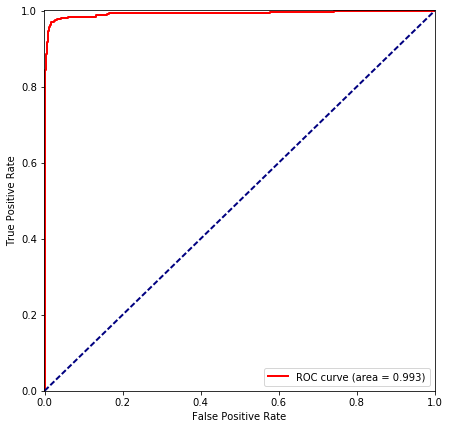

In [29]:
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.001, 1.0])
plt.ylim([0.0, 1.001])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Augmentation example

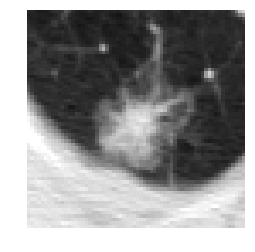

In [50]:
plt.imshow(X_cancer_nodules[17][32], vmin=-1100, vmax=200, cmap='gray')
plt.axis('off')
plt.show()

### Low-res, as used for training network

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


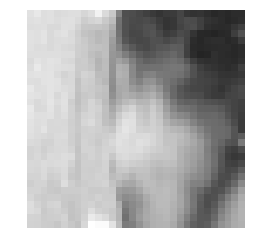

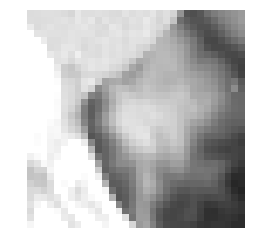

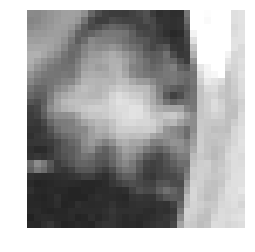

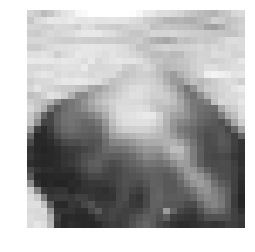

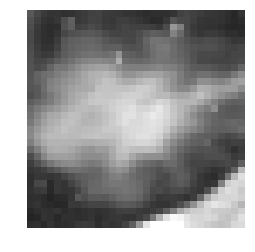

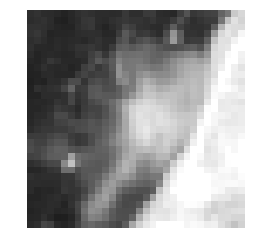

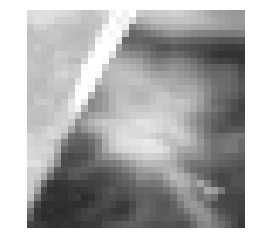

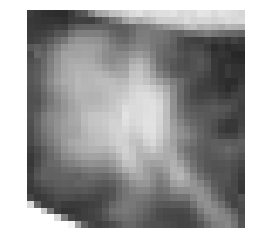

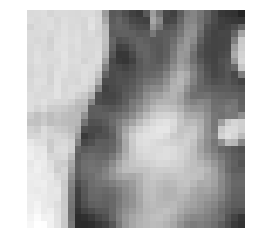

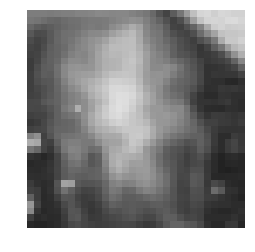

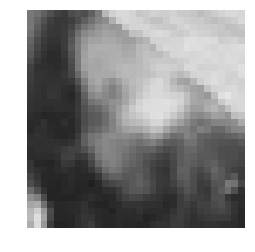

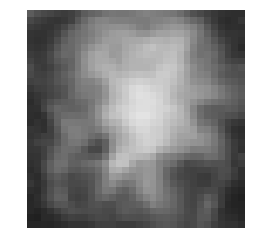

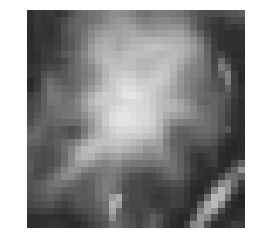

In [49]:
sgen = datagen.sample_generator(np.asarray((32,32,32)), patient_ids, X_cancer_nodules[17:18], cancer_diams[17:18])

for n in range(30):
    volume, is_augmented = next(sgen)
    if not is_augmented:
        continue
    plt.imshow(volume[16], vmin=-1100, vmax=200, cmap='gray')
    plt.axis('off')
    plt.show()

### High-res

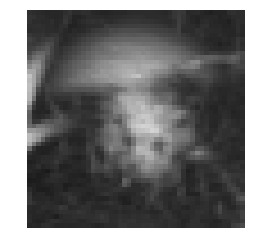

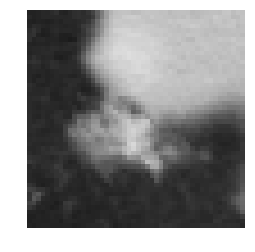

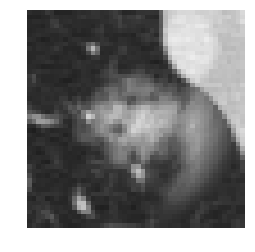

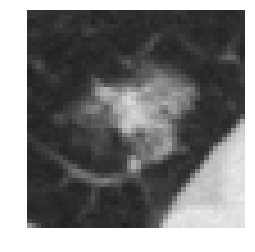

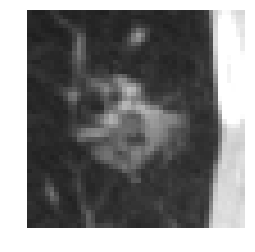

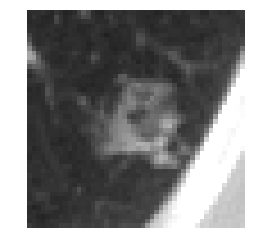

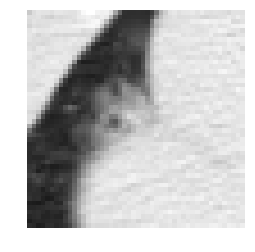

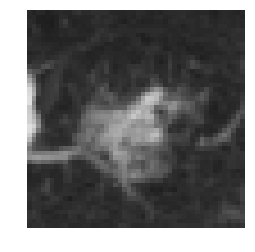

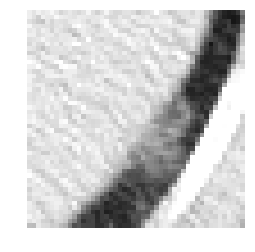

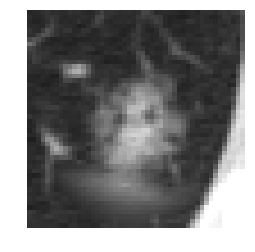

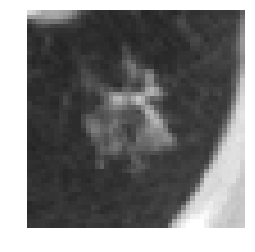

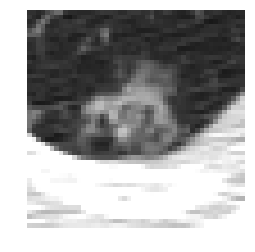

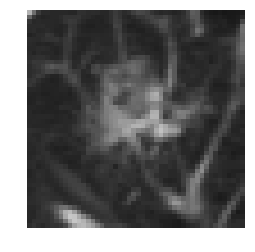

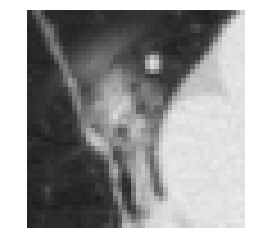

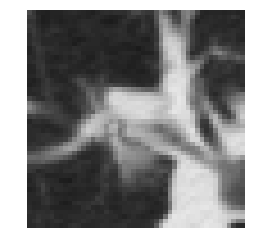

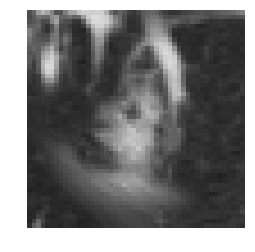

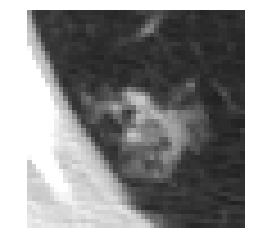

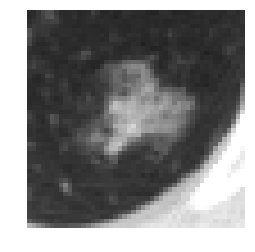

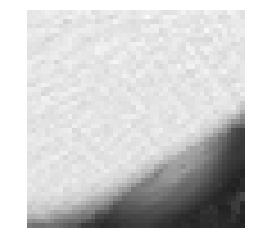

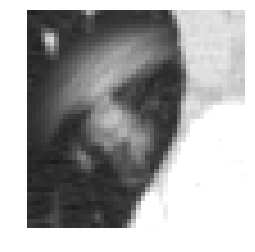

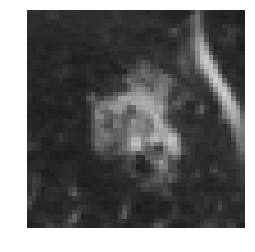

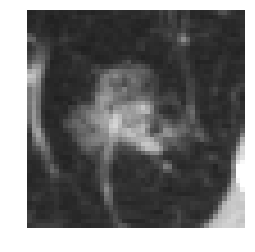

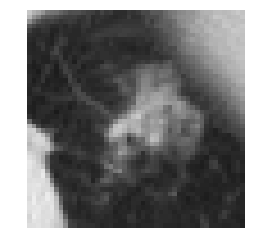

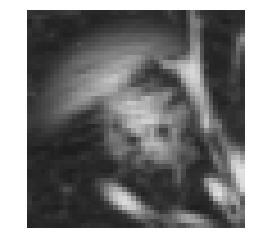

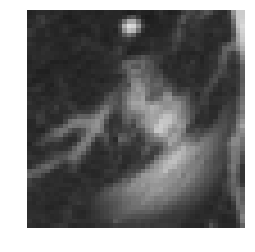

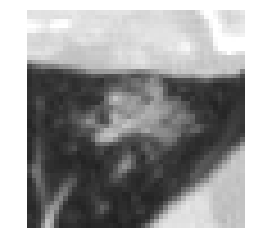

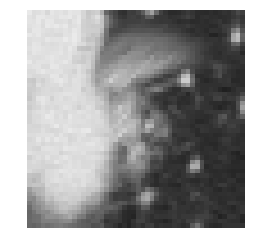

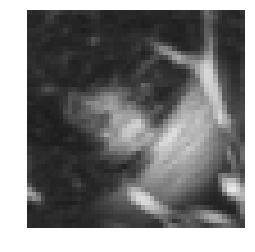

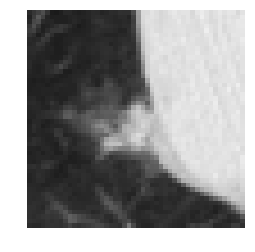

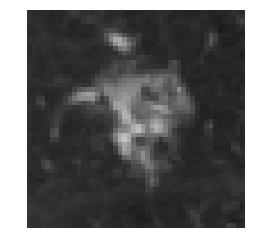

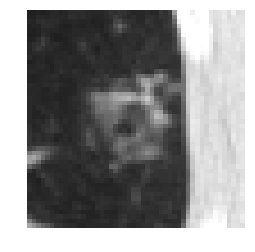

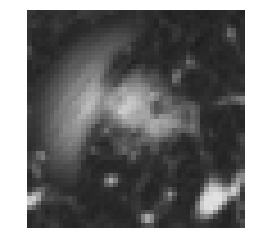

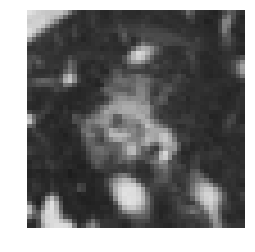

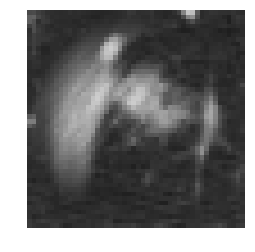

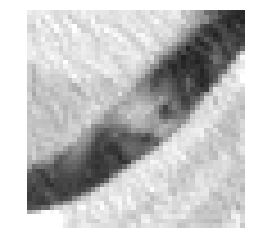

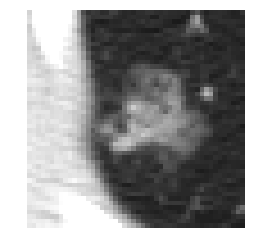

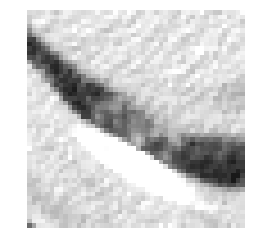

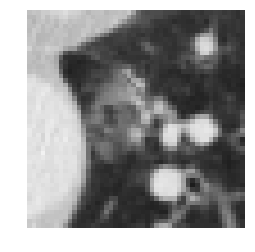

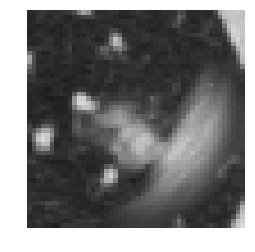

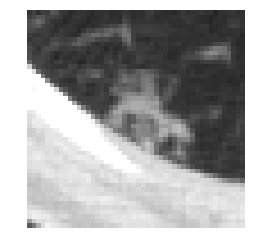

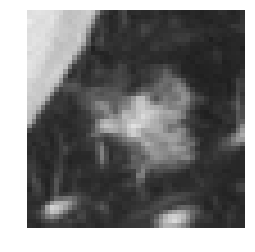

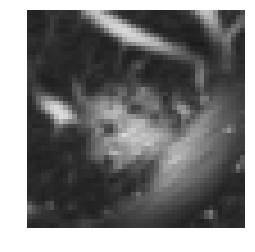

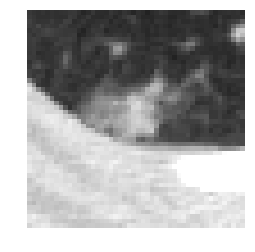

In [11]:
sgen = datagen.sample_generator(np.asarray((48,48,48)), patient_ids, X_cancer_nodules[17:18], cancer_diams[17:18])

for n in range(100):
    volume, is_augmented = next(sgen)
    if not is_augmented:
        continue
    plt.imshow(volume[16], vmin=-1100, vmax=200, cmap='gray')
    plt.axis('off')
    plt.show()